In [15]:
from pandas_datareader import data
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.dates import date2num
#from matplotlib.finance import candlestick_ohlc as candlestick
from mplfinance.original_flavor import candlestick_ohlc as candlestick # pls install matplotlib for candle stick plot 
import datetime
import requests

In [20]:
ticker = '7022.kl'
# Last 3 years closing prices starting from Jan 2, 2018.
 
now = datetime.datetime.now()
startyear = 2021
startmonth = 1 
startday = 2
start = datetime.datetime(startyear, startmonth, startday)
sec_id = pdr.get_data_yahoo(ticker, start, now)
sec_id.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-11-22,1.92,1.85,1.90,1.85,2440700.0,1.85
2021-11-23,1.86,1.76,1.85,1.76,5039700.0,1.76
2021-11-24,1.77,1.66,1.76,1.67,9124700.0,1.67
2021-11-25,1.76,1.68,1.68,1.73,3818600.0,1.73
2021-11-26,1.73,1.62,1.71,1.63,5881000.0,1.63


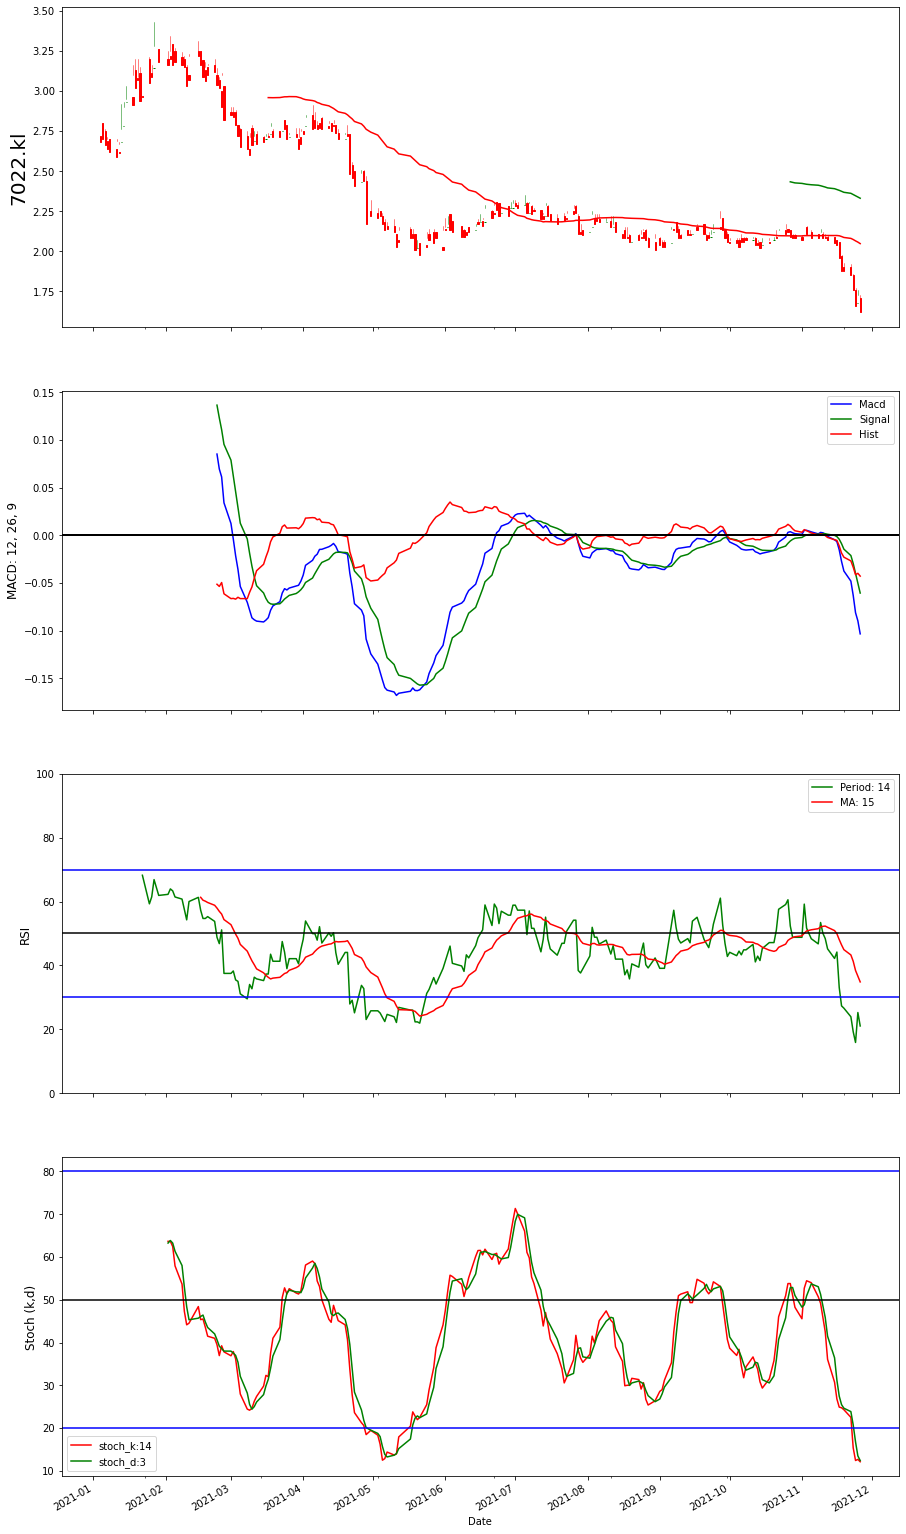

In [21]:

#ticker = 'OPK'

# Download sample data
#sec_id = data.get_data_yahoo(ticker, '2014-06-01')

# Data for matplotlib finance plot
sec_id_ochl = np.array(pd.DataFrame({'0':date2num(sec_id.index.to_pydatetime()),
                                  '1':sec_id.Open,
                                  '2':sec_id.Close,
                                  '3':sec_id.High,
                                  '4':sec_id.Low}))

# Technical Analysis
SMA_FAST = 50
SMA_SLOW = 200
RSI_PERIOD = 14
RSI_AVG_PERIOD = 15
MACD_FAST = 12
MACD_SLOW = 26
MACD_SIGNAL = 9
STOCH_K = 14
STOCH_D = 3
SIGNAL_TOL = 3
Y_AXIS_SIZE = 12

analysis = pd.DataFrame(index = sec_id.index)

#analysis['sma_f'] = pd.rolling_mean(sec_id.Close, SMA_FAST)
analysis['sma_f'] = sec_id.Close.rolling(SMA_FAST).mean()

#analysis['sma_s'] = pd.rolling_mean(sec_id.Close, SMA_SLOW)
analysis['sma_s'] = sec_id.Close.rolling(SMA_SLOW).mean()
#analysis['rsi'] = ta.RSI(sec_id.Close.as_matrix(), RSI_PERIOD)
analysis['rsi'] = ta.RSI(sec_id.Close.to_numpy(), RSI_PERIOD)
#analysis['sma_r'] = pd.rolling_mean(analysis.rsi, RSI_AVG_PERIOD) # check shift
analysis['sma_r'] = analysis.rsi.rolling(RSI_AVG_PERIOD).mean() # check shift

#analysis['macd'], analysis['macdSignal'], analysis['macdHist'] = ta.MACD(sec_id.Close.as_matrix(), fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)
analysis['macd'], analysis['macdSignal'], analysis['macdHist'] = ta.MACD(sec_id.Close.to_numpy(), fastperiod=MACD_FAST, slowperiod=MACD_SLOW, signalperiod=MACD_SIGNAL)
#analysis['stoch_k'], analysis['stoch_d'] = ta.STOCH(sec_id.High.as_matrix(), sec_id.Low.as_matrix(), sec_id.Close.as_matrix(), slowk_period=STOCH_K, slowd_period=STOCH_D)
analysis['stoch_k'], analysis['stoch_d'] = ta.STOCH(sec_id.High.to_numpy(), sec_id.Low.to_numpy(), sec_id.Close.to_numpy(), slowk_period=STOCH_K, slowd_period=STOCH_D)

analysis['sma'] = np.where(analysis.sma_f > analysis.sma_s, 1, 0)
analysis['macd_test'] = np.where((analysis.macd > analysis.macdSignal), 1, 0)
analysis['stoch_k_test'] = np.where((analysis.stoch_k < 50) & (analysis.stoch_k > analysis.stoch_k.shift(1)), 1, 0)
analysis['rsi_test'] = np.where((analysis.rsi < 50) & (analysis.rsi > analysis.rsi.shift(1)), 1, 0)

# Prepare plot
fig, (ax1, ax3, ax2, ax4) = plt.subplots(4, 1, sharex=True)
ax1.set_ylabel(ticker, size=20)

#size plot
fig.set_size_inches(15,30)

# Plot candles
candlestick(ax1, sec_id_ochl, width=0.5, colorup='g', colordown='r', alpha=1)

# Draw Moving Averages
analysis.sma_f.plot(ax=ax1, c='r')
analysis.sma_s.plot(ax=ax1, c='g')

#RSI
ax2.set_ylabel('RSI', size=Y_AXIS_SIZE)
analysis.rsi.plot(ax = ax2, c='g', label = 'Period: ' + str(RSI_PERIOD))
analysis.sma_r.plot(ax = ax2, c='r', label = 'MA: ' + str(RSI_AVG_PERIOD))
ax2.axhline(y=30, c='b')
ax2.axhline(y=50, c='black')
ax2.axhline(y=70, c='b')
ax2.set_ylim([0,100])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)

# Draw MACD computed with Talib
ax3.set_ylabel('MACD: '+ str(MACD_FAST) + ', ' + str(MACD_SLOW) + ', ' + str(MACD_SIGNAL), size=Y_AXIS_SIZE)
analysis.macd.plot(ax=ax3, color='b', label='Macd')
analysis.macdSignal.plot(ax=ax3, color='g', label='Signal')
analysis.macdHist.plot(ax=ax3, color='r', label='Hist')
ax3.axhline(0, lw=2, color='0')
handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels)

# Stochastic plot
ax4.set_ylabel('Stoch (k,d)', size=Y_AXIS_SIZE)
analysis.stoch_k.plot(ax=ax4, label='stoch_k:'+ str(STOCH_K), color='r')
analysis.stoch_d.plot(ax=ax4, label='stoch_d:'+ str(STOCH_D), color='g')
handles, labels = ax4.get_legend_handles_labels()
ax4.legend(handles, labels)
ax4.axhline(y=20, c='b')
ax4.axhline(y=50, c='black')
ax4.axhline(y=80, c='b')

plt.show()